In [64]:
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt 

In [109]:
final_date = datetime.datetime.now()
init_date = final_date - datetime.timedelta(days = 360 * 5)

In [110]:
final_date = final_date.strftime("%d/%m/%Y")
init_date = init_date.strftime("%d/%m/%Y")

In [111]:
init_date

'17/02/2017'

In [112]:
df = pd.DataFrame(index = pd.date_range(start = init_date, end = final_date, freq = 'SM'))
df.index.name = 'Data'

In [113]:
df['Aporte'] = 1000

In [114]:
df['Aporte'][:int(len(df)/2)] = 1000
df['Aporte'][int(len(df)/2):] = 5000

In [115]:
df['Acum. Aporte'] = df['Aporte'].cumsum()
df.head()

,Aporte,Acum. Aporte
Data,,
2017-02-28,1000,1000
2017-03-15,1000,2000
2017-03-31,1000,3000
2017-04-15,1000,4000
2017-04-30,1000,5000


In [116]:
response = requests.get(f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial={init_date}&dataFinal={final_date}')
response

<Response [200]>

In [117]:
selic_df = pd.DataFrame(response.json())
selic_df['Data'] = pd.to_datetime(selic_df['data'], infer_datetime_format= True)

selic_df = selic_df.set_index('Data').drop(columns = ['data'])
selic_df = selic_df.rename(columns = {'valor':'Selic'})
selic_df['Selic'] = pd.to_numeric(selic_df['Selic'], errors = 'raise')

selic_df.head()

,Selic
Data,
2017-02-17,0.048159
2017-02-20,0.048159
2017-02-21,0.048159
2017-02-22,0.048159
2017-02-23,0.045513


> https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases

In [118]:
df = df.resample('B').ffill()

In [119]:
final_df = pd.merge(df, right = selic_df, left_index=True, right_index=True)

In [120]:
final_df.dropna(how='any', inplace=True)

In [121]:
final_df['Acum. Selic'] = (final_df['Selic']/100 + 1).cumprod()
final_df['Pat. Acum.'] = final_df['Acum. Selic'] * final_df['Acum. Aporte']
final_df.head()

,Aporte,Acum. Aporte,Selic,Acum. Selic,Pat. Acum.
Data,,,,,
2017-03-01,1000,1000,0.045513,1.000455,1000.455130
2017-03-02,1000,1000,0.045513,1.000910,1000.910467
2017-03-03,1000,1000,0.045513,1.001366,1001.366012
2017-03-06,1000,1000,0.045513,1.001822,1001.821763
2017-03-07,1000,1000,0.045513,1.002278,1002.277722


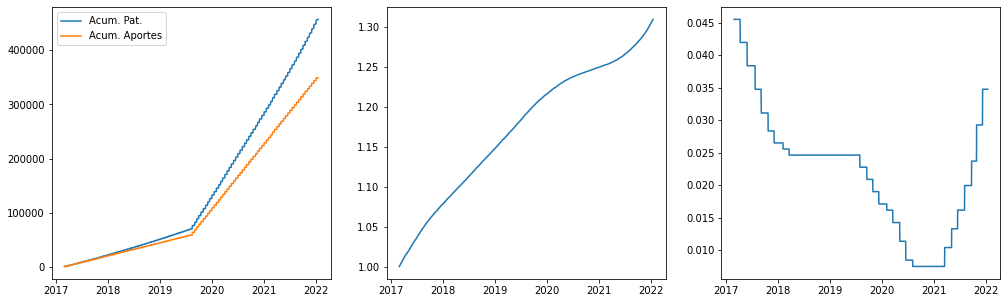

In [122]:
fig, ax = plt.subplots(1, 3, figsize = (17,5))

ax[0].plot(final_df['Pat. Acum.'], label = 'Acum. Pat.')
ax[0].plot(final_df['Acum. Aporte'], label = 'Acum. Aportes')

ax[0].legend()

ax[1].plot(final_df['Acum. Selic'])

ax[2].plot(final_df['Selic'])
plt.show()